## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [55]:
!pip install -q transformers datasets evaluate

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [56]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [57]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [58]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [59]:
from transformers import AutoImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [60]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [61]:
encoded_inputs = train_dataset[0]

In [62]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [63]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [64]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [65]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [66]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [67]:
batch = next(iter(train_dataloader))

In [68]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [69]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [70]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False,  True,  ...,  True, False, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [71]:
batch["labels"][mask]

tensor([2, 2, 2,  ..., 0, 0, 0])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [72]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [73]:
import evaluate

metric = evaluate.load("mean_iou")

In [74]:
image_processor.do_reduce_labels

True

In [75]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.122427940368652
Mean_iou: 0.00134098514176125
Mean accuracy: 0.02231038628321247
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.935277938842773
Mean_iou: 0.0005641003434604519
Mean accuracy: 0.0035678889616010995
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.708730220794678
Mean_iou: 0.007755203409067876
Mean accuracy: 0.07990786675652554
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.623031139373779
Mean_iou: 0.010744661966354102
Mean accuracy: 0.06358212512834394
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.392558574676514
Mean_iou: 0.0355819160719905
Mean accuracy: 0.36869866263670226
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.389269828796387
Mean_iou: 0.02754725372608861
Mean accuracy: 0.239367954732712
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.145265102386475
Mean_iou: 0.039352349930715916
Mean accuracy: 0.18425466377702157
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.1412482261657715
Mean_iou: 0.04327140195395254
Mean accuracy: 0.17112592687982708
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7790169715881348
Mean_iou: 0.07471487664338505
Mean accuracy: 0.2367856543585148
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.704113483428955
Mean_iou: 0.18716276030821957
Mean accuracy: 0.39404179587203403
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.257199764251709
Mean_iou: 0.19310047303860983
Mean accuracy: 0.49958668287431973
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.6191439628601074
Mean_iou: 0.1324061178985553
Mean accuracy: 0.33139232625565507
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.481764793395996
Mean_iou: 0.3598773546712052
Mean accuracy: 0.6109075304226093
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.459623336791992
Mean_iou: 0.20975136501360517
Mean accuracy: 0.39125493613305057
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.284257173538208
Mean_iou: 0.08489945122131258
Mean accuracy: 0.14519758014030457
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.012263774871826
Mean_iou: 0.09899843655775131
Mean accuracy: 0.21231535695780498
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8859565258026123
Mean_iou: 0.34959556932904445
Mean accuracy: 0.4403579495906503
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.827444314956665
Mean_iou: 0.10382226628555971
Mean accuracy: 0.2280966264749715
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.267305374145508
Mean_iou: 0.08337316087599475
Mean accuracy: 0.16502172362545037
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.586975336074829
Mean_iou: 0.12183642799103882
Mean accuracy: 0.2607221676966487
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7270638942718506
Mean_iou: 0.14277426260146686
Mean accuracy: 0.2679496256301774
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7895572185516357
Mean_iou: 0.12432162764429117
Mean accuracy: 0.21157499458338916
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.538386106491089
Mean_iou: 0.08523902489248297
Mean accuracy: 0.14425267103480063
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5965354442596436
Mean_iou: 0.29660203108889005
Mean accuracy: 0.4656768980058277
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8641109466552734
Mean_iou: 0.3238451691900694
Mean accuracy: 0.49887996469415097
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.331026077270508
Mean_iou: 0.3119896734531596
Mean accuracy: 0.38365147393069654
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4001941680908203
Mean_iou: 0.17374494076262686
Mean accuracy: 0.29837440893583345
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0000205039978027
Mean_iou: 0.257729469908273
Mean accuracy: 0.49960830350099955
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.385024070739746
Mean_iou: 0.3014329804268978
Mean accuracy: 0.4791565862149122
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7239307165145874
Mean_iou: 0.18359332708189335
Mean accuracy: 0.2771138494891469
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1558520793914795
Mean_iou: 0.4575685381662065
Mean accuracy: 0.692445392910434
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6401633024215698
Mean_iou: 0.5601781920040252
Mean accuracy: 0.8188277632337743
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0630552768707275
Mean_iou: 0.36473934539819775
Mean accuracy: 0.470782086311376
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0171773433685303
Mean_iou: 0.34168112003893103
Mean accuracy: 0.4718831770515531
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9551928043365479
Mean_iou: 0.49192610162570294
Mean accuracy: 0.6936875249451026
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.291884183883667
Mean_iou: 0.2680533879060912
Mean accuracy: 0.49697272989100577
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1151368618011475
Mean_iou: 0.16179603902660358
Mean accuracy: 0.21426668073050936
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5035886764526367
Mean_iou: 0.36890054653070936
Mean accuracy: 0.5395812862686002
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1867966651916504
Mean_iou: 0.4837826115507065
Mean accuracy: 0.636088008276598
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7947670221328735
Mean_iou: 0.24213278673419494
Mean accuracy: 0.36284486372032276
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9265458583831787
Mean_iou: 0.18201824553423143
Mean accuracy: 0.30504973612276337
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1314990520477295
Mean_iou: 0.21946199525300292
Mean accuracy: 0.3015941188138324
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8387582302093506
Mean_iou: 0.1023137877371407
Mean accuracy: 0.19870760664269352
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8893427848815918
Mean_iou: 0.25362703508224005
Mean accuracy: 0.3374355399098079
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.383425235748291
Mean_iou: 0.4580785253402928
Mean accuracy: 0.6112909051201776
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7819159030914307
Mean_iou: 0.3298083290085803
Mean accuracy: 0.4210138728933308
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8784370422363281
Mean_iou: 0.3337230424987758
Mean accuracy: 0.5311630494092944
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8217424154281616
Mean_iou: 0.3225176531132915
Mean accuracy: 0.39846377536804123
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4301295280456543
Mean_iou: 0.32229486219995296
Mean accuracy: 0.5497386380789173
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3751527070999146
Mean_iou: 0.25284737965777326
Mean accuracy: 0.46157392317772344
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2008167505264282
Mean_iou: 0.3229209277691727
Mean accuracy: 0.5278204014613783
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.516502857208252
Mean_iou: 0.20099573236998827
Mean accuracy: 0.32044913923934215
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8058550357818604
Mean_iou: 0.6107051019385017
Mean accuracy: 0.7918409590548354
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.791872262954712
Mean_iou: 0.12878745880390277
Mean accuracy: 0.20486129727272787
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8867732286453247
Mean_iou: 0.516214816850447
Mean accuracy: 0.6805383119655719
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3415586948394775
Mean_iou: 0.2135133900030319
Mean accuracy: 0.33886777405390167
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7429707050323486
Mean_iou: 0.5342640701265181
Mean accuracy: 0.6911078727526091
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4025249481201172
Mean_iou: 0.3808850266992659
Mean accuracy: 0.5202035704507533
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4182195663452148
Mean_iou: 0.19313291742270114
Mean accuracy: 0.30560720068810143
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7815019488334656
Mean_iou: 0.4695449560063987
Mean accuracy: 0.7134541552972099
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2778229713439941
Mean_iou: 0.10312585912196325
Mean accuracy: 0.16387162366682373
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0470818281173706
Mean_iou: 0.2599666780319817
Mean accuracy: 0.40120751447287284
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4295310974121094
Mean_iou: 0.3675345181558251
Mean accuracy: 0.5370371251834793
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3086204528808594
Mean_iou: 0.4991374579171126
Mean accuracy: 0.6312263905021722
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9137414693832397
Mean_iou: 0.4561356642626516
Mean accuracy: 0.611981257032194
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7891951203346252
Mean_iou: 0.3208186189880654
Mean accuracy: 0.5451011190375931
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.033015489578247
Mean_iou: 0.2875005263564708
Mean accuracy: 0.406375986910022
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.573645830154419
Mean_iou: 0.7690165874008129
Mean accuracy: 0.844950391421676
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3171435594558716
Mean_iou: 0.13089860177920895
Mean accuracy: 0.20448127826704451
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0615513324737549
Mean_iou: 0.5571241678321452
Mean accuracy: 0.6333114897216416
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2364258766174316
Mean_iou: 0.4333163889230755
Mean accuracy: 0.7228207743184926
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5942508578300476
Mean_iou: 0.3673741306668966
Mean accuracy: 0.5229673908932858
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2561815977096558
Mean_iou: 0.48607593487057077
Mean accuracy: 0.5840587207138578
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9440196752548218
Mean_iou: 0.21771543906583077
Mean accuracy: 0.2831181748489728
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.613908052444458
Mean_iou: 0.6475039510585372
Mean accuracy: 0.8318326337150658
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0090333223342896
Mean_iou: 0.5332213388779056
Mean accuracy: 0.606278513405237
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9076531529426575
Mean_iou: 0.648511186388596
Mean accuracy: 0.7916708615373541
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6514841914176941
Mean_iou: 0.3020867322776596
Mean accuracy: 0.5485772558088938
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0108213424682617
Mean_iou: 0.18152039447092205
Mean accuracy: 0.3258385917207284
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3919013738632202
Mean_iou: 0.6527102290086331
Mean accuracy: 0.841274851765653
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9562467336654663
Mean_iou: 0.5527029305320348
Mean accuracy: 0.627996595748043
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9015481472015381
Mean_iou: 0.3961000521614571
Mean accuracy: 0.48337119594625394
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8705073595046997
Mean_iou: 0.5819980335085715
Mean accuracy: 0.6607638488011504
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1304429769515991
Mean_iou: 0.2233735725125463
Mean accuracy: 0.33903459132427766
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8329885005950928
Mean_iou: 0.5829457477964495
Mean accuracy: 0.6608722223696974
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8969570994377136
Mean_iou: 0.5631442165978113
Mean accuracy: 0.6589740426997219
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8351600170135498
Mean_iou: 0.2003054959919711
Mean accuracy: 0.3587209262218901
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6731142401695251
Mean_iou: 0.3453290199203993
Mean accuracy: 0.5015513860526886
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6904633045196533
Mean_iou: 0.6625509988412533
Mean accuracy: 0.7980220706106393
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0458670854568481
Mean_iou: 0.4133852487950957
Mean accuracy: 0.5113883682425957
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9140082001686096
Mean_iou: 0.3068128938621913
Mean accuracy: 0.436602017112036
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39199015498161316
Mean_iou: 0.7175610244238575
Mean accuracy: 0.8217626868910588
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5461031794548035
Mean_iou: 0.5014723398327527
Mean accuracy: 0.5969967997805702
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6736180186271667
Mean_iou: 0.24989201171263223
Mean accuracy: 0.4593799556027661
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7695675492286682
Mean_iou: 0.5641076405622673
Mean accuracy: 0.6714368124629083
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7707374691963196
Mean_iou: 0.5997519289295662
Mean accuracy: 0.6740498818095019
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8803306221961975
Mean_iou: 0.3801549956608392
Mean accuracy: 0.5593508420817767
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8733345866203308
Mean_iou: 0.2555018509667198
Mean accuracy: 0.3306101455127533
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7525085806846619
Mean_iou: 0.37836682643540503
Mean accuracy: 0.47351252908874075
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0210466384887695
Mean_iou: 0.310093606928531
Mean accuracy: 0.3994713554493188
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.72126305103302
Mean_iou: 0.6318647954009003
Mean accuracy: 0.6659491202947665
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7780001759529114
Mean_iou: 0.27105895295743654
Mean accuracy: 0.3424978382807732
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4481034278869629
Mean_iou: 0.3148560452695228
Mean accuracy: 0.6278839370598367
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7384029626846313
Mean_iou: 0.45109363871830715
Mean accuracy: 0.5271559034837632
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.703416645526886
Mean_iou: 0.5851949858116435
Mean accuracy: 0.6569467611933856
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7836676239967346
Mean_iou: 0.2521151150174946
Mean accuracy: 0.37708581010324516
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6898883581161499
Mean_iou: 0.4220173689997292
Mean accuracy: 0.5443078196233228
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6697822213172913
Mean_iou: 0.5874220983425155
Mean accuracy: 0.6628684395994071
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4413627088069916
Mean_iou: 0.5198205289158502
Mean accuracy: 0.6190514873931404
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7184973359107971
Mean_iou: 0.45788965609980853
Mean accuracy: 0.5329038105712924
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6654704213142395
Mean_iou: 0.3536475410100668
Mean accuracy: 0.42197235175342
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5990463495254517
Mean_iou: 0.5890049708850503
Mean accuracy: 0.6676980775836614
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6588892340660095
Mean_iou: 0.23039491194868467
Mean accuracy: 0.4084542521613963
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39550209045410156
Mean_iou: 0.4911787614459386
Mean accuracy: 0.5874081646148659
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6560234427452087
Mean_iou: 0.466016871177699
Mean accuracy: 0.5112643577676168
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6345604062080383
Mean_iou: 0.2912481699362117
Mean accuracy: 0.37868455271383705
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7645094394683838
Mean_iou: 0.37941219987123315
Mean accuracy: 0.5228559060057683
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24513410031795502
Mean_iou: 0.8284477284204839
Mean accuracy: 0.8476943131058389
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6100720167160034
Mean_iou: 0.4102037251970922
Mean accuracy: 0.5863369207068146
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3876045048236847
Mean_iou: 0.5102362752801265
Mean accuracy: 0.6800900383731436
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6017535924911499
Mean_iou: 0.29241769668138967
Mean accuracy: 0.37423281724436497
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8185509443283081
Mean_iou: 0.20026355412442934
Mean accuracy: 0.29206363826477405
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6215279698371887
Mean_iou: 0.33316025494297274
Mean accuracy: 0.43853134009059125
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5356001257896423
Mean_iou: 0.8133890157896623
Mean accuracy: 0.8663859875395102
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9056784510612488
Mean_iou: 0.32320406326653417
Mean accuracy: 0.40214017190859835
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7489421367645264
Mean_iou: 0.3028650490487893
Mean accuracy: 0.40095120500665343
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6005666851997375
Mean_iou: 0.4264559843789388
Mean accuracy: 0.5217283261225699
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8330339193344116
Mean_iou: 0.19842612408837274
Mean accuracy: 0.29154422787186596
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3535386323928833
Mean_iou: 0.3884567124406022
Mean accuracy: 0.6706287096000104
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5559048056602478
Mean_iou: 0.7039066746324926
Mean accuracy: 0.7453085094286807
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6177137494087219
Mean_iou: 0.599154743463519
Mean accuracy: 0.6687120509270746
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40508562326431274
Mean_iou: 0.8243953691876648
Mean accuracy: 0.8808753520993484
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6981884241104126
Mean_iou: 0.37419270056447124
Mean accuracy: 0.4606939109329391
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20928193628787994
Mean_iou: 0.9197664235854519
Mean accuracy: 0.9416553726700596
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7097064256668091
Mean_iou: 0.4921480315554281
Mean accuracy: 0.5481555973786378
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5012314319610596
Mean_iou: 0.642246727149404
Mean accuracy: 0.674573764992063
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6273971796035767
Mean_iou: 0.37757332335183913
Mean accuracy: 0.5054735394239199
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19262142479419708
Mean_iou: 0.930237120677148
Mean accuracy: 0.9483182628452174
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6390620470046997
Mean_iou: 0.24537383993857717
Mean accuracy: 0.3263877760622246
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5222763419151306
Mean_iou: 0.34799365378231406
Mean accuracy: 0.4362907509198937
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6471689343452454
Mean_iou: 0.4118335247227929
Mean accuracy: 0.47807611393314126
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.521264910697937
Mean_iou: 0.33637417094975636
Mean accuracy: 0.457812974964112
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3666498064994812
Mean_iou: 0.6480784271214765
Mean accuracy: 0.7585631733475978
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1909133493900299
Mean_iou: 0.838240174952425
Mean accuracy: 0.8562622674688207
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32955214381217957
Mean_iou: 0.6006354473900952
Mean accuracy: 0.6765046231140778
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5786624550819397
Mean_iou: 0.4790037922870558
Mean accuracy: 0.567876667977075
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2971074879169464
Mean_iou: 0.5434059633075166
Mean accuracy: 0.6066207409390254
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47409772872924805
Mean_iou: 0.5351418691462481
Mean accuracy: 0.5896773093392602
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5868465900421143
Mean_iou: 0.5655294780326406
Mean accuracy: 0.6445309396872378
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4272274971008301
Mean_iou: 0.5907544337484119
Mean accuracy: 0.6613986725657128
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19994206726551056
Mean_iou: 0.8329250370525714
Mean accuracy: 0.8482101127373405
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7382248044013977
Mean_iou: 0.23951121077813606
Mean accuracy: 0.31255291114754
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5054110884666443
Mean_iou: 0.609415856152767
Mean accuracy: 0.6761585179476857
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35377442836761475
Mean_iou: 0.3800809877536264
Mean accuracy: 0.5557896494752919
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5947396159172058
Mean_iou: 0.45300083731952134
Mean accuracy: 0.495946484278684
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29767173528671265
Mean_iou: 0.43029247137163595
Mean accuracy: 0.6166433618663637
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25965800881385803
Mean_iou: 0.4591322620827045
Mean accuracy: 0.7671938244872825
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3400733470916748
Mean_iou: 0.43935589956343357
Mean accuracy: 0.6028957953328761
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3310277760028839
Mean_iou: 0.32466432714372856
Mean accuracy: 0.5521008738786908
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2664616107940674
Mean_iou: 0.6571002640607042
Mean accuracy: 0.6886413206623329
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6855064034461975
Mean_iou: 0.42060530012666614
Mean accuracy: 0.5839812436120153
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29540368914604187
Mean_iou: 0.9157946665626377
Mean accuracy: 0.9418462786855224
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3767659664154053
Mean_iou: 0.3192443542261908
Mean accuracy: 0.5474502151001277
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5346538424491882
Mean_iou: 0.3051364674644827
Mean accuracy: 0.4607005945839479
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3199930787086487
Mean_iou: 0.8817455333180206
Mean accuracy: 0.9163294981699046
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7156777381896973
Mean_iou: 0.2324451259025592
Mean accuracy: 0.32912593211186947
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4451587498188019
Mean_iou: 0.31461689504820917
Mean accuracy: 0.39221933425320205
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3676706552505493
Mean_iou: 0.7414722896231979
Mean accuracy: 0.7844796801925047
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.521170973777771
Mean_iou: 0.37177562134396586
Mean accuracy: 0.4454614624213845
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.362435519695282
Mean_iou: 0.3743398037765812
Mean accuracy: 0.5499423063040354
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4429369270801544
Mean_iou: 0.5042166827945792
Mean accuracy: 0.5894109159061999
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4322108030319214
Mean_iou: 0.34858137796930544
Mean accuracy: 0.42702494619390935
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12332853674888611
Mean_iou: 0.8378350834349745
Mean accuracy: 0.8615670214802511
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41374650597572327
Mean_iou: 0.3503687664206398
Mean accuracy: 0.44280318373767974
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3508063554763794
Mean_iou: 0.7314841439755309
Mean accuracy: 0.7606511327177393
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23783154785633087
Mean_iou: 0.8503910414888886
Mean accuracy: 0.884194649995547
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2957284152507782
Mean_iou: 0.8654145628949607
Mean accuracy: 0.9415646973736553
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3893221914768219
Mean_iou: 0.5422690391249219
Mean accuracy: 0.5798371142856775
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25998032093048096
Mean_iou: 0.6964581152845134
Mean accuracy: 0.8105317482062186
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46154943108558655
Mean_iou: 0.37649469594610047
Mean accuracy: 0.4388072538006358
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2892846465110779
Mean_iou: 0.5455311828551439
Mean accuracy: 0.6061738377593207
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41792720556259155
Mean_iou: 0.27950654516560325
Mean accuracy: 0.39973956394305415
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6110039949417114
Mean_iou: 0.37371781542240406
Mean accuracy: 0.45720086899943746
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3539477586746216
Mean_iou: 0.5494494589135781
Mean accuracy: 0.5916504710114724
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22044287621974945
Mean_iou: 0.5190114820206603
Mean accuracy: 0.7482175641715827
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3494342863559723
Mean_iou: 0.5316025756612024
Mean accuracy: 0.6177511153890038
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33663928508758545
Mean_iou: 0.5633118627889593
Mean accuracy: 0.6179708259604868
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28459927439689636
Mean_iou: 0.6963668721354966
Mean accuracy: 0.720959530155082
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20813409984111786
Mean_iou: 0.3788166751815803
Mean accuracy: 0.7305475100471335
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1645210087299347
Mean_iou: 0.8345035229223687
Mean accuracy: 0.8537993872212404
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2923967242240906
Mean_iou: 0.8186373524289707
Mean accuracy: 0.8557167683602788
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4953095316886902
Mean_iou: 0.2932421318798958
Mean accuracy: 0.3786990547627189
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18063251674175262
Mean_iou: 0.5799396862952455
Mean accuracy: 0.6243567072069649
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23516421020030975
Mean_iou: 0.7066093346786649
Mean accuracy: 0.8302515458030411
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34390753507614136
Mean_iou: 0.38054366854650906
Mean accuracy: 0.458444485503643
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4124022424221039
Mean_iou: 0.5604908034443178
Mean accuracy: 0.641366732613198
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15384867787361145
Mean_iou: 0.44549742950398763
Mean accuracy: 0.7546231295277879
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33610713481903076
Mean_iou: 0.24915788385772392
Mean accuracy: 0.36776755951188705
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29654598236083984
Mean_iou: 0.5895997126772707
Mean accuracy: 0.6272961053282526
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21855570375919342
Mean_iou: 0.6634867858470175
Mean accuracy: 0.7353993237150729


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

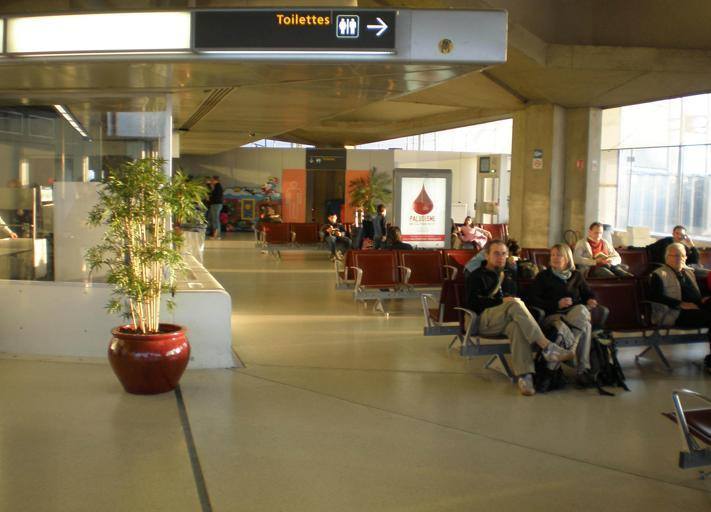

In [76]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg')
image

In [77]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [78]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [79]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [80]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [81]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


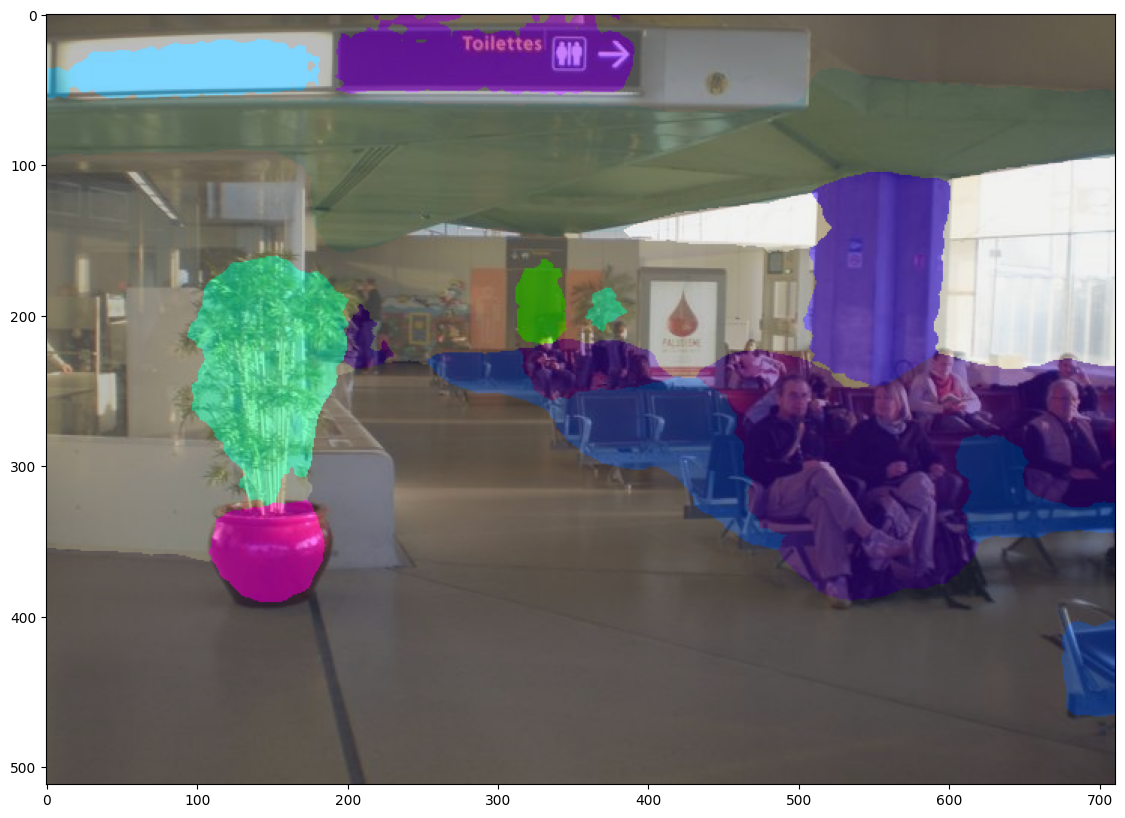

In [82]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

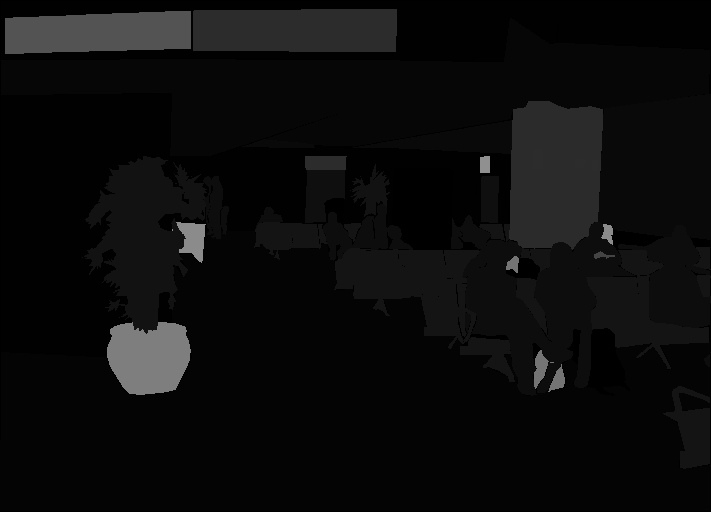

In [83]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000002.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'person', 'door', 'plant', 'chair', 'column', 'signboard', 'book', 'light', 'bag', 'pot', 'ashcan', 'monitor', None]


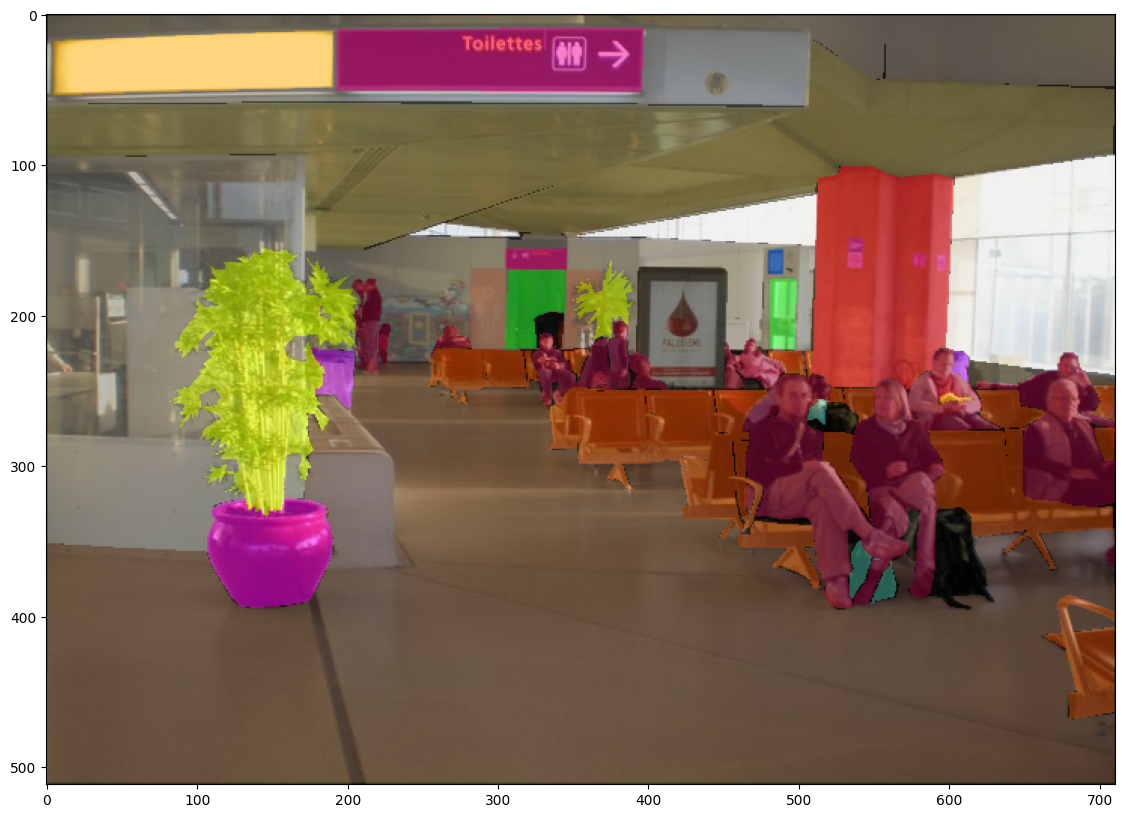

In [84]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [85]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [86]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [87]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.5730714954385747
mean_accuracy 0.6221314933207835
overall_accuracy 0.9198624649676262
---------------------
per-category metrics:


IoU  accuracy
wall      0.821299  0.945241
building       NaN       NaN
sky            NaN       NaN
floor     0.963457  0.984040
tree           NaN       NaN
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag           NaN       NaN

[150 rows x 2 columns]

In [88]:
metric_table

{'wall': [0.8212988249442538, 0.9452414250493808],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9634572261245282, 0.9840395818370441],
 'tree': [nan, nan],
 'ceiling': [0.9353210217466345, 0.9600726354717984],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.8918947648153069, 0.9573824737562757],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.690338836947152, 0.9250111061750333],
 'earth': [nan, nan],
 'door': [0.4178163184864013, 0.4446308724832215],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.752497380370241, 0.8486567399353975],
 'curtain': [nan, nan],
 'chair': [0.6267193245267602, 0.6645807259073843],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
 '

Processing image: /content/ADE20k_toy_dataset/images/validation/ADE_val_00000004.jpg
Image loaded successfully


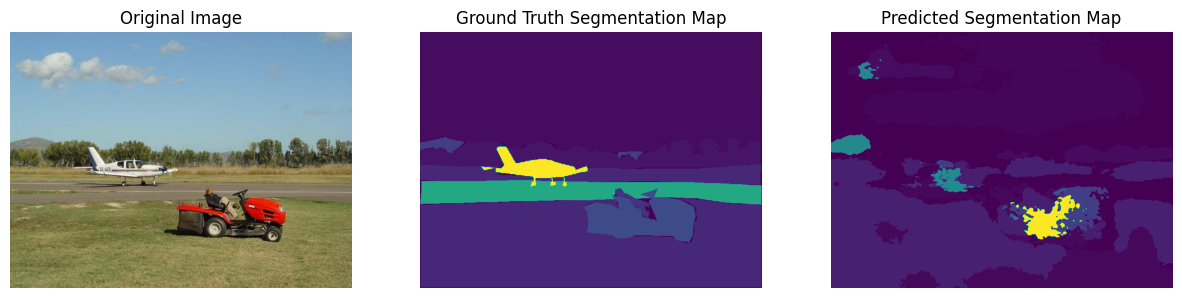

Metrics for Image saved to /content/ADE_val_00000004.jpg.csv
Processing image: /content/ADE20k_toy_dataset/images/validation/ADE_val_00000008.jpg
Image loaded successfully


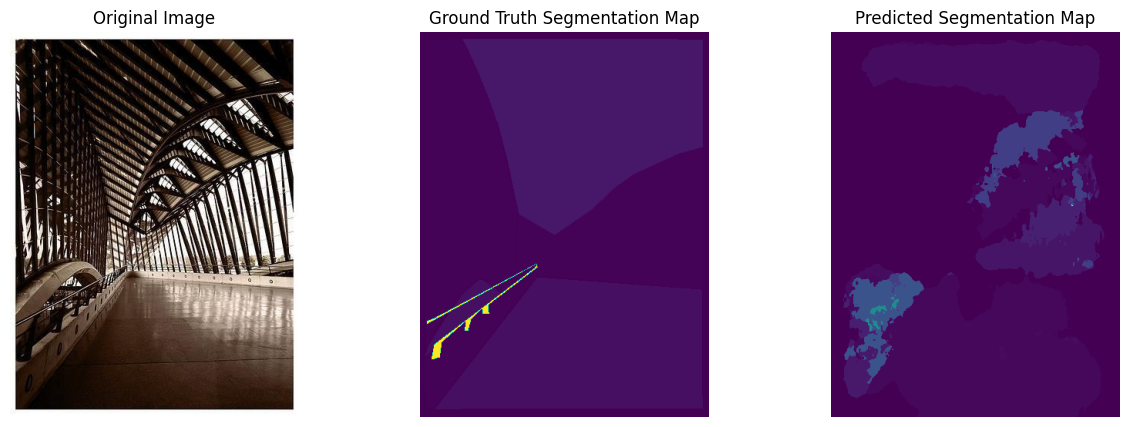

Metrics for Image saved to /content/ADE_val_00000008.jpg.csv
Processing image: /content/ADE20k_toy_dataset/images/validation/ADE_val_00000007.jpg
Image loaded successfully


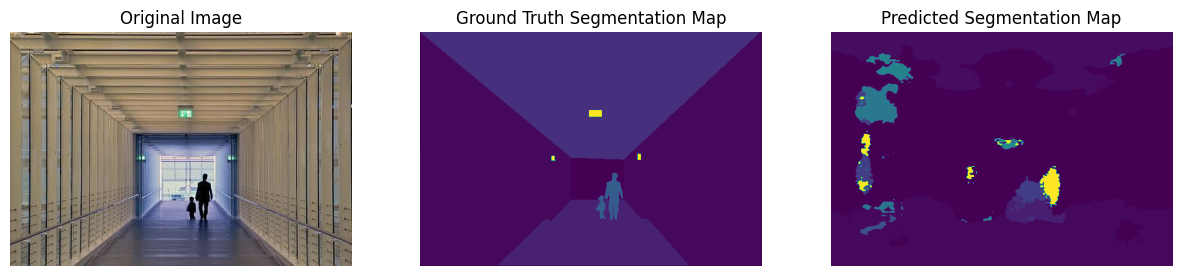

Metrics for Image saved to /content/ADE_val_00000007.jpg.csv


In [104]:
import random
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your dataset directory
dataset_dir = "/content/ADE20k_toy_dataset"

# Define image_files as a list of image file paths in your dataset directory
training_image_files = os.listdir(os.path.join(dataset_dir, "images", "training"))
validation_image_files = os.listdir(os.path.join(dataset_dir, "images", "validation"))

# Combine training and validation image files
image_files = [os.path.join(dataset_dir, "images", "training", filename) for filename in training_image_files] + \
              [os.path.join(dataset_dir, "images", "validation", filename) for filename in validation_image_files]

# Select 3 images randomly
sample_image_paths = random.sample(image_files, min(len(image_files), 3))

# Filter out directories from sample_image_paths
sample_image_paths = [path for path in sample_image_paths if os.path.isfile(path)]

# Create a list to store the metrics for each image
image_metrics = []

# Loop through each sample image
for image_path in sample_image_paths:
    try:
        print("Processing image:", image_path)
        # Load the image
        image = Image.open(image_path)
        print("Image loaded successfully")

        # Prepare the image for the model (assuming `image_processor` and `device` are defined elsewhere)
        pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)

        # Post-process the segmentation map
        predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
        predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

        # Load the ground truth segmentation map
        ground_truth_map_path = image_path.replace("images", "annotations").replace(".jpg", ".png")
        ground_truth_map = Image.open(ground_truth_map_path)
        ground_truth_map = np.array(ground_truth_map)

        # Load the reference segmentation map
        reference_segmentation_map = Image.open(image_path.replace("images", "annotations").replace(".jpg", ".png"))
        reference_segmentation_map = np.array(reference_segmentation_map)

        # Evaluate the generated segmentation map
        metrics = metric._compute(
            predictions=[predicted_segmentation_map],
            references=[reference_segmentation_map],
            num_labels=len(id2label),
            ignore_index=255
        )

        # Append the metrics to the list
        image_metrics.append(metrics)

        # Visualize the image, ground truth segmentation map, and predicted segmentation map
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_map)
        plt.title("Ground Truth Segmentation Map")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_segmentation_map)
        plt.title("Predicted Segmentation Map")
        plt.axis("off")

        plt.show()

        # Prepare data for CSV
        data = {"Metric": list(metrics.keys()), "Value": list(metrics.values())}
        df = pd.DataFrame(data)

        # Save the metrics to a CSV file
        csv_filename = f"{os.path.basename(image_path)}.csv"
        csv_path = os.path.join("/content", csv_filename)
        df.to_csv(csv_path, index=False)
        print(f"Metrics for Image saved to {csv_path}")

    except Exception as e:
        print("An error occurred while processing the image:", image_path)
        print("Error details:", e)
